## Path sampling

This notebook contains the code for Qijia's path sampling idea.

First, imports:

In [1]:
import jax
import jax.numpy as jnp
from nn import MLP, train
import numpy as np
import matplotlib.pyplot as plt
import optax 
import scipy
import os


`batch_size` is the number of paths (that we use each time we update the drift)

`ndims` is the number of dimensions of the problem. Here we work with a TPS example, of a double well in 2D.

In [2]:
# this allows for parallelization with pmap. Not currently used
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=" + str(100)

# currently we're just doing an SDE on \mathbb{R}
ndims = 1


We now define a function that generates random paths given a drift term `b` and a noise term `W`:

In [3]:


def sample_sde(b, W, rho, dt, num_steps, key):

    """
    Sample a path of the SDE defined by b, W, and rho.
    b: drift term. A function from R^ndims x R -> R^ndims
    W: noise term
    rho: initial distribution to sample from
    dt: time step size
    num_steps: number of time steps to take along the path
    key: random key for sampling

    Returns:

    array of size [batch_size, num_steps, ndims] containing the sampled paths
    """

    init_key, run_key = jax.random.split(key)
    X_0 = rho(init_key)

    def body(X_and_t, key):
        X, time = X_and_t

        new_X = X + b(X, time) * dt + W(X_0, key) * jnp.sqrt(dt)
        new_time = time + dt
        return ((new_X, new_time), (new_X, new_time))

    keys = jax.random.split(run_key, num_steps-1)
    path, time =  jax.lax.scan(body, (X_0, 0), keys)[1]
    return jnp.concat((X_0[None], path), axis=0), jnp.concat((jnp.zeros(1,), time), axis=0)


## Example of a path in a double well

Here's an example of sampling a path in a double well potential.

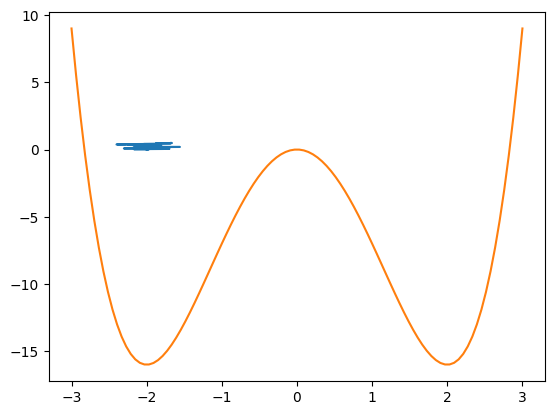

In [4]:
hyperparams={'dt': 0.01, 'num_steps': 50, 'num_training_steps' : 1000}


def uref(x, t): 
    potential = lambda x: jnp.sum(x**4 - 8 * x**2,axis=-1)
    return -jax.grad(potential)(x)

path, time = sample_sde(
    b=uref, 
    W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,)),
    rho = lambda key: jnp.zeros((ndims,))-2.,
    key=jax.random.key(0), 
    dt=hyperparams['dt'], 
    num_steps=hyperparams['num_steps'])

# visualize path
plt.plot(path,time)
# plot potential
potential = lambda x: jnp.sum(x**4 - 8 * x**2,axis=-1)
x = np.linspace(-3, 3, 100)

plt.plot(x, potential(x[:, None]))

In [5]:
# currently set for TPS
def J(x,y):
    """
    x: path of the SDE, array of shape [num_steps, ndims]
    y: observation, here ignored, so assume it's `None`

    Returns:
        a scalar value representing the cost of the path
    """

    sigma = 0.1
    return (1/sigma**2)*(x[-1,0]- 2)**2

# vmap is a jax function that allows us to apply a function to each element of an array
def E_J(paths, obs):
    """
    paths: array of shape [batch_size, num_steps, ndims]
    obs: here can just be None
    Returns:
        a scalar value representing the mean cost of the paths
    """
    return jnp.mean(jax.vmap(J)(paths, obs),axis=0)


We can then calculate a path cost `J(x)` as follows:

In [6]:
cost = J(path, None)
print("Cost of path: ", cost)


Cost of path:  1347.4712


# Defining h

We now define `h`

In [7]:
def make_h(b, dbds):
    """
    b: drift term. A function from R^ndims x R -> R^ndims
    dbds: also a function from R^ndims x R -> R^ndims
    Returns:
        a function h, as defined below
    """

    @jax.jit # this speeds up the function
    def h(x, time):
        """
        x: path of the SDE, array of shape [num_steps, ndims]
        time: array of shape [num_steps]
        Returns:
            a scalar value representing the cost of the path
        """
        dt = time[1]

        # a crude approximation of the derivative
        dxdts = jnp.concatenate([jnp.zeros((1, x.shape[1])) , x[1:, :] - x[:-1, :]], axis=0)/ dt

        # calculate divergence of dbds at all times, using the trace of the jacobian
        div_dbdss = jax.vmap(lambda xt, t: jnp.trace(jax.jacobian(lambda k: dbds(k,t))(xt)))(x, time)

        # the discretized integral
        out = jax.vmap(lambda x, t, dxdt, div_dbds: 
                    
                    -0.5*dt*((b(x,t) - dxdt).dot(dbds(x,t)) + 0.5*div_dbds)
                    )(x,time, dxdts, div_dbdss)
        
        return jnp.sum(out) 

    return h

# compute the loss function, which here is the square of the difference between the left and right of (7)
def make_h_loss(expectation_of_J, b):
    """
    expectation_of_J: the expectation of J, computed from the paths
    b: drift term. A function from R^ndims x R -> R^ndims
    Returns:
        a function h_loss, which computes the loss
    """
    
    def h_loss(dbds, xs, times, ys):
        """
        xs: array of shape [batch_size, num_steps, ndims]
        times: array of shape [batch_size, num_steps]
        ys: for current purposes, just None
        Returns:
            a scalar value representing the loss
        """

        h = make_h(b, dbds)

        expectation_of_h = jnp.mean(jax.vmap(h)(xs, times), axis=0)

        return jnp.sum(jax.vmap(lambda x,y, t: (-J(x, y)+expectation_of_J - h(x,t) + expectation_of_h)**2)(xs, ys, times))

    return h_loss        


In [8]:
def find_dbds(model_key, expectation_of_J, b, xs, times, ys, num_training_steps):
    """
    model_key: random key for the model
    expectation_of_J: the expectation of J, computed from the paths
    b: drift term. A function from R^ndims x R -> R^ndims
    xs: array of shape [batch_size, num_steps, ndims]
    times: array of shape [batch_size, num_steps]
    ys: for current purposes, just None
    num_training_steps: number of training steps to take
    Returns:
        dbds: the trained model, which is a function from R^ndims x R -> R^ndims
    """

    dbds = MLP([2,20,20,1], key=model_key) # create an NN, with random weights
    learning_rate = 1e-3
    optimizer = optax.adam(learning_rate)
    h_loss = make_h_loss(expectation_of_J, b)
    dbds = train(h_loss, dbds, optimizer, num_training_steps, xs, times, ys)
    return dbds

# b \mapsto b + dbds
# Pseudo code:
# create `xs` of shape [batch_size, num_steps, ndims]
# calculate expectation of J
# initialize a neural net as function from R^ndims x R -> R^ndims
# fit weights of neural net according to the loss function
# calculate test loss
# return lambda x: b(x) + dbds(x)
def update(b, hyperparams, key, i):
    """
    b: drift term. A function from R^ndims x R -> R^ndims
    hyperparams: dictionary of hyperparameters
    key: random key for the model
    i: index for the current iteration (just for labelling plots)
    Returns:
        new_b: the updated drift term, which is a function from R^ndims x R -> R^ndims
    """

    path_key, model_key = jax.random.split(key)

    xs, times = jax.pmap(lambda key:sample_sde(
    b=b, 
    W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,)),
    rho = lambda key: jnp.ones((ndims,))-2.,
    key=key, 
    dt=hyperparams['dt'], 
    num_steps=hyperparams['num_steps']))(jax.random.split(path_key, hyperparams['batch_size']))


    plot = True
    if plot:

        x = jnp.expand_dims(jnp.linspace(-5, 5, 100), 1)
        y = (x**4 - 8 * x**2)
        plt.ylim(-15,15)
        if i==0: plt.plot(x, y)
        plt.plot(xs[0],(times[0]/hyperparams['dt'])/5, label=i)
        # plt.savefig('potential_new.png')
        plt.legend()

    expectation_of_J = E_J(xs, None)

    dbds = find_dbds(
        model_key,
        expectation_of_J,
        b,
        xs,
        times,
        None,
        num_training_steps=hyperparams['num_training_steps']
        )
    
    ### calculate test loss
    test_xs, test_times = jax.pmap(lambda key:sample_sde(
        b=b, 
        W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,)),
        rho = lambda key: jnp.zeros((ndims,))-2.,
        key=key, 
        dt=hyperparams['dt'], 
        num_steps=hyperparams['num_steps']))(jax.random.split(jax.random.key(500), hyperparams['batch_size']))

    print(f"Test loss is {make_h_loss(expectation_of_J=expectation_of_J, b=b)(dbds, test_xs, test_times, None)}")

    ###

    
    new_b =  lambda x, t: (b(x,t) + dbds(x,t))
    return new_b


Train loss: 24559.60546875
Test loss is 6577274.0
Train loss: 1888.3134765625
Test loss is 4743.86083984375
Train loss: 51.526092529296875
Test loss is 182.67701721191406
Train loss: 48.00471878051758
Test loss is 37.03657531738281


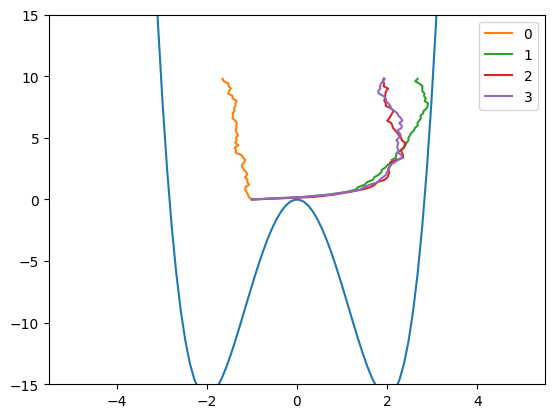

In [9]:
key = jax.random.key(0)
b = uref # initialize b as uref
schedule = [0.0, 0.1, 0.2, 0.3] # , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
for i, _ in enumerate(schedule):

    key = jax.random.fold_in(key, i)

    # update b -> b + dbds
    b = update(b=b,
        hyperparams={'dt': 0.001, 'num_steps': 50, 'num_training_steps' : 5000, 'batch_size' : 50},
        key=key,
        i=i
    )

## Everything below here is a work in progress, ignore for now!

In [6]:

import blackjax

def run_mclmc(logdensity_fn, num_steps, initial_position, key, transform, desired_energy_variance= 5e-4):
    init_key, tune_key, run_key = jax.random.split(key, 3)

    # create an initial state for the sampler
    initial_state = blackjax.mcmc.mclmc.init(
        position=initial_position, logdensity_fn=logdensity_fn, rng_key=init_key
    )

    # build the kernel
    kernel = lambda inverse_mass_matrix : blackjax.mcmc.mclmc.build_kernel(
        logdensity_fn=logdensity_fn,
        integrator=blackjax.mcmc.integrators.isokinetic_mclachlan,
        inverse_mass_matrix=inverse_mass_matrix,
    )

    # find values for L and step_size
    (
        blackjax_state_after_tuning,
        blackjax_mclmc_sampler_params,
        _
    ) = blackjax.mclmc_find_L_and_step_size(
        mclmc_kernel=kernel,
        num_steps=num_steps,
        state=initial_state,
        rng_key=tune_key,
        diagonal_preconditioning=False,
        desired_energy_var=desired_energy_variance
    )

    # use the quick wrapper to build a new kernel with the tuned parameters
    sampling_alg = blackjax.mclmc(
        logdensity_fn,
        L=blackjax_mclmc_sampler_params.L,
        step_size=blackjax_mclmc_sampler_params.step_size,
    )

    # run the sampler
    _, samples = blackjax.util.run_inference_algorithm(
        rng_key=run_key,
        initial_state=blackjax_state_after_tuning,
        inference_algorithm=sampling_alg,
        num_steps=num_steps,
        transform=transform,
        progress_bar=True,
    )

    return samples, blackjax_state_after_tuning, blackjax_mclmc_sampler_params, run_key


In [60]:
def I(x, time, u):

    dt = time[1]

    dxdts = jnp.concatenate([jnp.zeros((1,)) , x[1:] - x[:-1]], axis=0)
    print(dxdts.shape)


        # calculate divergence of dbds at all times, using the trace of the jacobian
    div_us = jax.vmap(lambda xt, t: (jax.jacobian(lambda k: u(k,t))(xt)))(x, time)



    out = jax.vmap(lambda xt,t, div_u, dxdt : 0.5*dt*((dxdt - u(xt, t)).dot(dxdt - u(xt, t))) + 0.5*div_u)(x, time, div_us, dxdts)

    return jnp.sum(out)


In [95]:
hyperparams={'dt': 0.01, 'num_steps': 50, 'num_training_steps' : 1000}
path_key = jax.random.key(0)
xs, times = jax.pmap(lambda key:sample_sde(
    b=b, 
    W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,)),
    rho = lambda key: jax.random.normal(key, shape=(ndims,))-2,
    key=key, 
    dt=hyperparams['dt'], 
    num_steps=hyperparams['num_steps']))(jax.random.split(path_key, batch_size))

x = xs[0, :, 0]
times[0].shape

# potential = lambda x: (x**4 - 8 * x**2)

schedule = [0.0, 0.1] # , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


def new_b(x, t): 
    # assert x.shape[0] == ndims
    return -jax.grad(lambda x: (x**4 - 8 * x**2))(x)

# x[0]
# print(new_b(x[0],times[0][0]))

# I(x,times[0], new_b)
-J(jnp.expand_dims(x,1), None)

Array(-19.048677, dtype=float32)

In [101]:
def new_b(x, t): 
    # assert x.shape[0] == ndims
    return -jax.grad(lambda x: (x**4 - 8 * x**2))(x)


time = np.arange(1,hyperparams['num_steps']+1)*hyperparams['dt']
# use onsager machlup here
logdensity_fn = lambda x: jax.scipy.stats.norm.logpdf(x[0], loc=-2, scale=1) - I(x, time, new_b) - jnp.linalg.norm(x[-1] - 2)**2
# jax.scipy.stats.norm.pdf(x[-1], loc=2, scale=1)

num_steps = 100000
transform = lambda state, info: state.position

hyperparams={'dt': 0.01, 'num_steps': 50, 'num_training_steps' : 1000}
path_key = jax.random.key(0)
xs, times = jax.pmap(lambda key:sample_sde(
    b=b, 
    W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,)),
    rho = lambda key: jax.random.normal(key, shape=(ndims,))-2,
    key=key, 
    dt=hyperparams['dt'], 
    num_steps=hyperparams['num_steps']))(jax.random.split(path_key, batch_size))

initial_position = xs[0, :, 0]

# print(initial_position.shape)
# raise Exception

rng_key = jax.random.PRNGKey(0)
sample_key, rng_key = jax.random.split(rng_key)
samples, initial_state, params, chain_key = run_mclmc(
    logdensity_fn=logdensity_fn,
    num_steps=num_steps,
    initial_position=initial_position,
    key=sample_key,
    transform=transform,
)

print(samples.shape)



(50,)
(50,)
(50,)
(50,)
(50,)
(50,)
(50,)


(100000, 50)


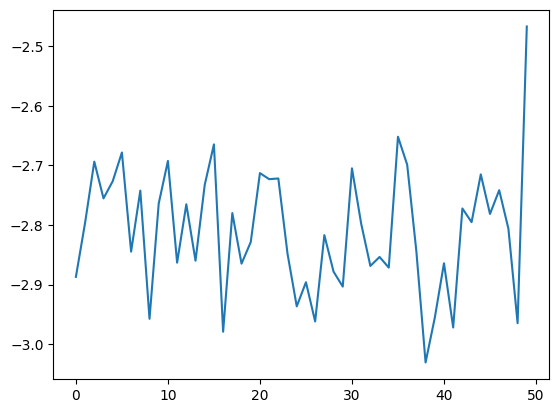

In [102]:
# plot samples[-1]
samples.shape
plt.plot(samples[0, :])